In [1]:
import numpy as np
np.random.seed(777)
from scipy.stats import gaussian_kde

observations = np.load("Obs_doublewell_k=0.9.npy")
observation_times = np.load("Obs_time_doublewell_k=0.9.npy")
mcmc_initial = np.load("samples10000.npy")
all_predictions = np.load("pinn_bayes_solutions_0_50_k_0.9_1.npy")

In [2]:
def drift(state):
    return 4 * state - 4 * state**3

def simulate_sde(noise_strength, final_time, time_step, initial_state):
    steps = int(final_time / time_step)
    trajectory = np.zeros(steps)
    trajectory[0] = initial_state
    noise = np.random.normal(0, np.sqrt(time_step), size=steps)
    for i in range(1, steps):
        trajectory[i] = trajectory[i-1] + drift(trajectory[i-1]) * time_step + noise_strength * noise[i-1]
    return trajectory

def initialize_particles(num_particles):
    particles = np.random.normal(0, 0.4, size=num_particles)
    weights = np.ones(num_particles) / num_particles
    return particles, weights

def forecast(particles, noise_strength, time_step):
    noise = np.random.normal(0, np.sqrt(time_step), size=len(particles))
    particles += drift(particles) * time_step + noise_strength * noise
    return particles

def update_weights(particles, observation, obs_std, weights):
    likelihoods = np.exp(-0.5 * ((observation - particles) / obs_std)**2)
    weights *= likelihoods
    weight_sum = np.sum(weights)
    if weight_sum == 0 or np.isnan(weight_sum):
        weights.fill(1.0 / len(weights))
    else:
        weights /= weight_sum
    return weights

def resample(particles, weights):
    if np.any(np.isnan(weights)):
        print("Warning: NaN in weights, resampling failed.")
    else:
        indices = np.random.choice(range(len(weights)), size=len(weights), p=weights)
        particles = particles[indices]
    return particles

def estimate_state(particles):
    return np.mean(particles)

def compute_mode_and_ci(particles, bandwidth='silverman', confidence=0.68):
    density = gaussian_kde(particles, bw_method=bandwidth)
    eval_points = np.linspace(min(particles), max(particles), 1000)
    density_vals = density(eval_points)
    mode = eval_points[np.argmax(density_vals)]
    peak_val = density_vals[np.argmax(density_vals)]
    threshold = peak_val * confidence
    ci_lower = eval_points[np.where(density_vals >= threshold)[0][0]]
    ci_upper = eval_points[np.where(density_vals >= threshold)[0][-1]]
    return mode, (ci_lower, ci_upper)

final_time = 50
time_step = 0.01
initial_state = 0.0
noise_strength = 0.9
total_steps = int(final_time / time_step)
obs_std = 0.2
obs_frequency = 100

num_particles = 10000
particles, weights = initialize_particles(num_particles)
particles = mcmc_initial

positions = np.zeros((total_steps, num_particles))
means = np.zeros(total_steps)
stds = np.zeros(total_steps)
modes = np.zeros(total_steps)
mode_ci_lower = np.zeros(total_steps)
mode_ci_upper = np.zeros(total_steps)

positions[0, :] = particles
means[0] = estimate_state(particles)
stds[0] = np.std(particles)

for t in range(1, total_steps):
    particles = forecast(particles, noise_strength, time_step)
    if t % obs_frequency == 0:
        obs_idx = t // obs_frequency
        obs = observations[obs_idx]
        weights = update_weights(particles, obs, obs_std, weights)
        particles = resample(particles, weights)
    weights = np.ones(num_particles) / num_particles
    means[t] = estimate_state(particles)
    stds[t] = np.std(particles)
    positions[t, :] = particles
    mode, mode_ci = compute_mode_and_ci(particles)
    modes[t] = mode
    mode_ci_lower[t] = mode_ci[0]
    mode_ci_upper[t] = mode_ci[1]

time_axis = np.linspace(0, time_step * all_predictions.shape[1], all_predictions.shape[1])
grid_points = 401
domain_bound = 2
spatial_grid = np.linspace(-domain_bound, domain_bound, grid_points)
grid_spacing = spatial_grid[1] - spatial_grid[0]
reference_modes = spatial_grid[np.argmax(all_predictions, axis=0)]
reference_means = np.sum(spatial_grid[:, None] * all_predictions * grid_spacing, axis=0)

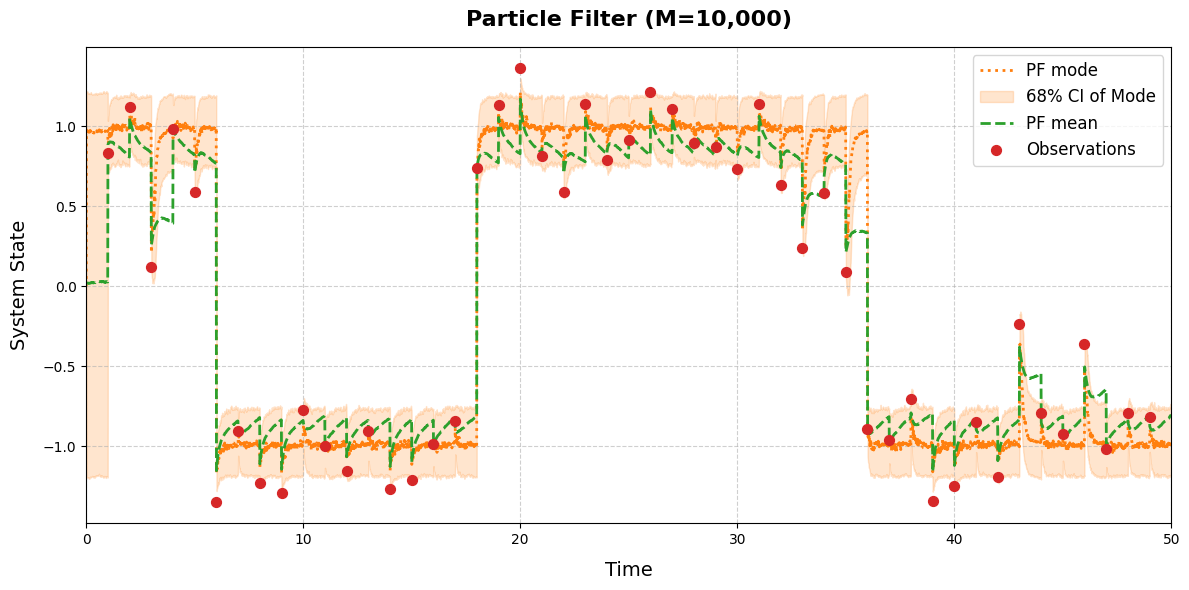

In [3]:
import matplotlib.pyplot as plt
# First plot: Mode and Mean
plt.figure(figsize=(12, 6))
plt.plot(time_axis, modes, label="PF mode", color="#ff7f0e", linestyle=":", linewidth=2)
plt.fill_between(time_axis, mode_ci_lower, mode_ci_upper, color="#ff7f0e", alpha=0.2, label="68% CI of Mode")
plt.plot(time_axis, means, label="PF mean", color="#2ca02c", linestyle="--", linewidth=2)
plt.scatter(observation_times[1:50], observations[1:50], label="Observations", color="#d62728", s=50, zorder=2)
plt.xlabel("Time", fontsize=14, labelpad=10)
plt.ylabel("System State", fontsize=14, labelpad=10)
plt.title("Particle Filter (M=10,000)", fontsize=16, fontweight="bold", pad=15)
plt.legend(fontsize=12, loc="upper right", frameon=True)
plt.xlim(0, 50)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("Mode_and_Mean_PF.png", dpi=300, bbox_inches="tight")
plt.show()

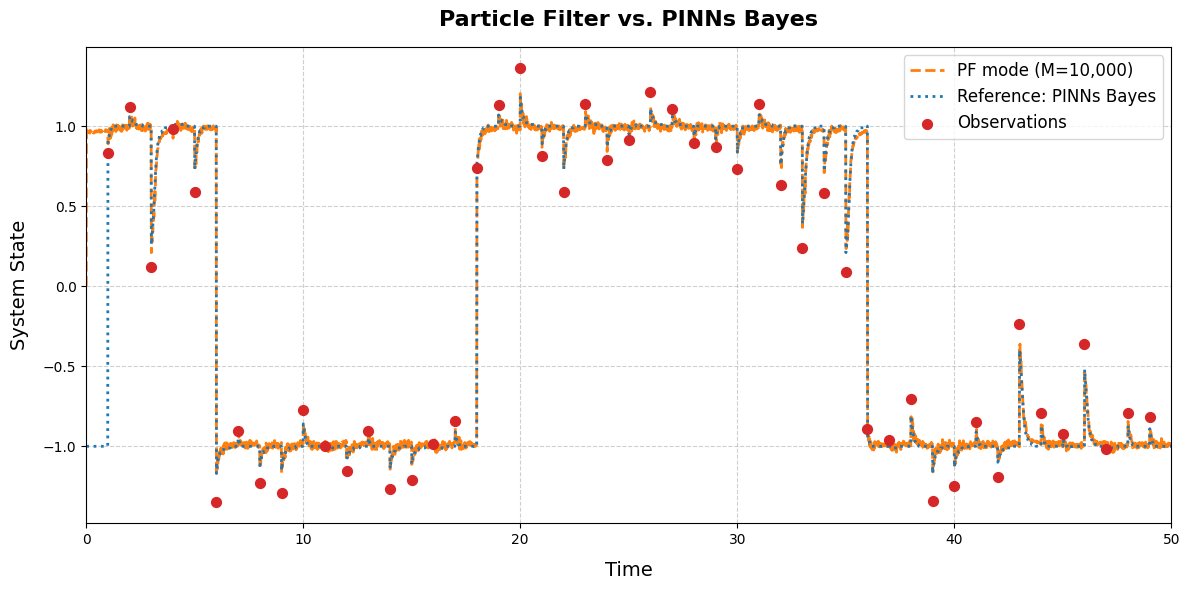

In [4]:
# Second plot: Mode Comparison
plt.figure(figsize=(12, 6))
plt.plot(time_axis, modes, label="PF mode (M=10,000)", color="#ff7f0e", linestyle="--", linewidth=2)
plt.plot(time_axis, reference_modes, label="Reference: PINNs Bayes", color="#1f77b4", linestyle=":", linewidth=2)
plt.scatter(observation_times[1:50], observations[1:50], label="Observations", color="#d62728", s=50, zorder=2)
plt.xlabel("Time", fontsize=14, labelpad=10)
plt.ylabel("System State", fontsize=14, labelpad=10)
plt.title("Particle Filter vs. PINNs Bayes", fontsize=16, fontweight="bold", pad=15)
plt.legend(fontsize=12, loc="upper right", frameon=True)
plt.xlim(0, 50)
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("Mode_Comparison_PINNs_Bayes_PF.png", dpi=300, bbox_inches="tight")
plt.show()